---
### 5. 연합뉴스 타이틀 주제 분류
- Dacon KLUE 데이터셋 
---

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import koreanize_matplotlib
import warnings
warnings.filterwarnings("ignore")

In [2]:
#!pip install konlpy
#!pip install tqdm

In [3]:
train = pd.read_csv('data/klue/train_data.csv') 
test = pd.read_csv('data/klue/test_data.csv') 
topic = pd.read_csv('data/klue/topic_dict.csv') 
print(train.shape, test.shape, topic.shape)

(45654, 3) (9131, 2) (7, 2)


In [4]:
train.head(2)

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4


In [5]:
test.head(2)

,index,title
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사


In [6]:
topic

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


---
#### 1. EDA & Preprocessing 
---

In [7]:
## 일괄 전처리를 위해 train, test set 병합 
raw = pd.concat([train, test]) 
raw.shape

(54785, 3)

In [8]:
## topic(name) merge 
df = raw.merge(topic, how = 'left') 
df.head()

,index,title,topic_idx,topic
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4.0,세계
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4.0,세계
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4.0,세계
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4.0,세계
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4.0,세계


4.0    7629
2.0    7362
5.0    6933
6.0    6751
1.0    6222
3.0    5933
0.0    4824
Name: topic_idx, dtype: int64


<AxesSubplot: xlabel='count', ylabel='topic'>

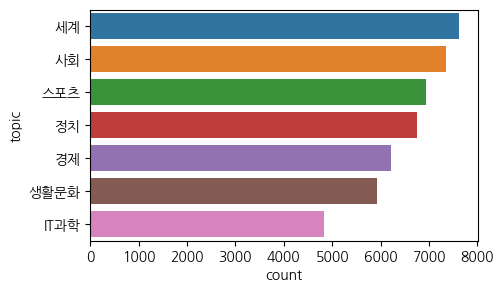

In [9]:
## target value = topic_idx의 분포 확인 
print(df['topic_idx'].value_counts())
plt.figure(figsize = (5,3)) 
sns.countplot(data = df, y='topic', order = df['topic'].value_counts().index)

In [10]:
## text 데이터 현황 확인 : title의 text 길이, word 수 컬럼 생성  
## set() : 중복을 허용하지 않음 
df['len'] = df['title'].apply(lambda x : len(x)) 
df['word_count'] = df['title'].apply(lambda x : len(x.split())) 
df['unique_word_count'] = df['title'].apply(lambda x : len(set(x.split())))

df.head()

,index,title,topic_idx,topic,len,word_count,unique_word_count
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4.0,세계,24,5,5
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4.0,세계,30,6,6
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4.0,세계,30,8,8
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4.0,세계,32,7,7
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4.0,세계,25,7,7


<AxesSubplot: xlabel='unique_word_count', ylabel='Count'>

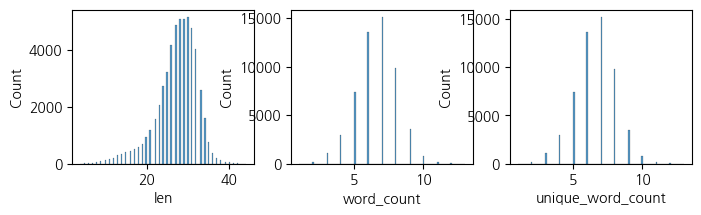

In [11]:
fig, axes = plt.subplots(1,3, figsize = (8,2)) 
sns.histplot(df['len'], ax=axes[0])
sns.histplot(df['word_count'], ax=axes[1])
sns.histplot(df['unique_word_count'], ax=axes[2])

In [12]:
df[['len', 'word_count', 'unique_word_count']].describe()

,len,word_count,unique_word_count
count,54785.000000,54785.000000,54785.000000
mean,27.318846,6.587880,6.576198
std,4.947738,1.471852,1.465320
min,4.000000,1.000000,1.000000
25%,25.000000,6.000000,6.000000
50%,28.000000,7.000000,7.000000
75%,31.000000,8.000000,8.000000
max,44.000000,13.000000,13.000000


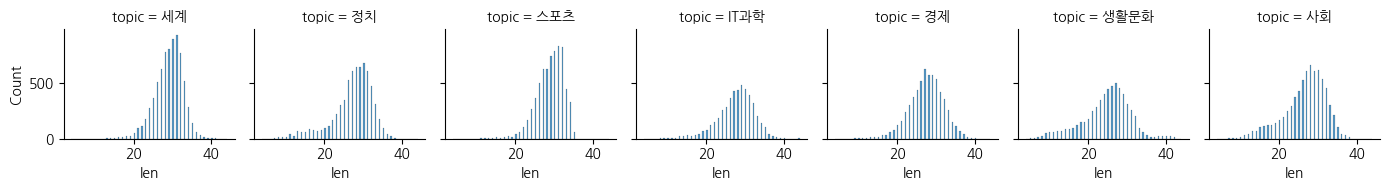

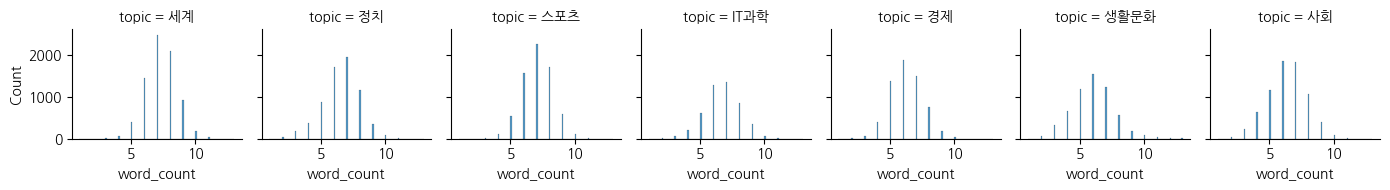

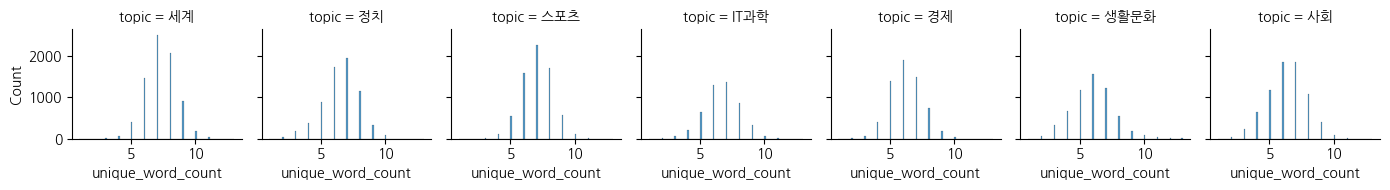

In [13]:
## topic별 등장빈도 시각화 비교 
sns.displot(data=df, x="len", col="topic", col_wrap=7, height=2)
sns.displot(data=df, x="word_count", col="topic", col_wrap=7, height=2)
sns.displot(data=df, x="unique_word_count", col="topic", col_wrap=7, height=2)

---
#### 2. Text Preprocessing 
- Okt().pos(~, stem=True) : 텍스트 추출하고 품사를 태깅, stem=True로 어간추출 
---

In [14]:
## 텍스트에서 숫자 제거 & 영문자 소문자로 변경 
import re
df['title'] = df['title'].str.replace('[0-9]','',regex=True)
df['title'] = df['title'].str.lower()

In [15]:
## 형태소 분석기 Okt 사용
## okt_clean 함수 : 텍스트에서 품사 추출 -> 조사,어미,구두점 제거 -> 어간 추출하여 토큰화 
from konlpy.tag import Okt 
from tqdm import tqdm 
tqdm.pandas()

okt = Okt()

def okt_clean(text) : 
    clean_text = []
    for word in okt.pos(text, stem=True): 
        if word[1] not in ['Josa', 'Eomi', 'Punctutation'] : 
            clean_text.append(word[0]) 
    return " ".join(clean_text)

train['title'] = train['title'].progress_map(okt_clean)
test['title'] = test['title'].progress_map(okt_clean)

100%|████████████████████████████████████████████████████████████████████████████| 9131/9131 [00:08<00:00, 1140.08it/s]


In [16]:
## stop word : 텍스트 분리 -> 토큰 -> stopword 제거 -> 정제된 문장 반환 
def remove_stopwords(text): 
    tokens = text.split(' ') 
    stops = [ '합니다', '하는', '할', '하고', '한다', '그리고', '입니다', '그 ', ' 등', '이런', ' 것 ', ' 및 ',' 제 ', ' 더 '] 
    meaningful_words = [w for w in tokens if not w in stops] 
    return ' '.join(meaningful_words)

In [17]:
df['title'] = df['title'].map(remove_stopwords)

In [18]:
## train/test dataset 분리 : topic_idx값이 없으면 test
train = df[df['topic_idx'].notnull()]
test = df[df['topic_idx'].isnull()]
print(train.shape, test.shape)

(45654, 7) (9131, 7)


In [19]:
X_train = train['title'] 
X_test = test['title'] 
y_train = train['topic_idx']
y_test = test['topic_idx']
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(45654,) (9131,) (45654,) (9131,)


In [20]:
print(y_train.value_counts(),'\n' , y_test.value_counts())

4.0    7629
2.0    7362
5.0    6933
6.0    6751
1.0    6222
3.0    5933
0.0    4824
Name: topic_idx, dtype: int64 
 Series([], Name: topic_idx, dtype: int64)


---
#### 3. TfidfVectorizer() 
---

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(tokenizer = None, 
                             ngram_range = (1,2), 
                             min_df = 3, max_df = 0.95) 

train_feature_tfidf = tfidf_vect.fit_transform(X_train)
test_feature_tfidf = tfidf_vect.transform(X_test)  ## test set에는 fit을 적용하지 않음 

print(train_feature_tfidf.shape, test_feature_tfidf.shape)

(45654, 22377) (9131, 22377)


In [22]:
vocab = tfidf_vect.get_feature_names_out()
print(len(vocab))
print(vocab[:10])

22377
['aa로' 'abs' 'acl' 'afc' 'afc 챔스리그' 'afc 챔피언십' 'afc 회장' 'ag' 'ag 우승' 'ai']


In [23]:
## tf-idf 가중치가 적용된 토큰들의 빈도 
a = np.sum(train_feature_tfidf, axis = 0) 
b = pd.DataFrame(a, columns = vocab)
b

,aa로,abs,acl,afc,afc 챔스리그,afc 챔피언십,afc 회장,ag,ag 우승,ai,...,힘으로,힘은,힘이,힘입어,힘찬,힙합,女농구대표팀,女배구,女배구 대표팀,ｍ짜리
0,1.374165,1.493937,4.560771,10.036045,3.516982,2.254818,1.220953,14.847285,1.557569,74.285975,...,4.326381,3.062647,1.748944,2.051542,2.495783,1.965046,1.537386,8.787677,2.478833,1.40821


<AxesSubplot: >

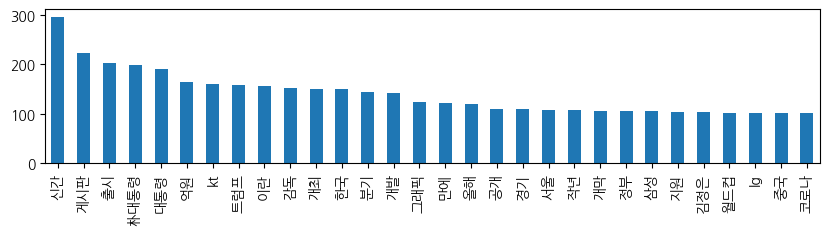

In [46]:
## Top 30, Bottom 30 시각화 
c = b.T[0].sort_values(ascending = False).head(30)
d = b.T[0].sort_values(ascending = True).head(30)

plt.figure(figsize = (10,2))
c.plot.bar()

<AxesSubplot: >

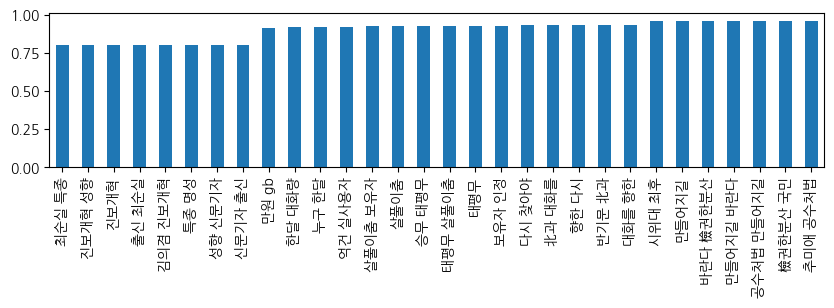

In [45]:
plt.figure(figsize = (10,2))
d.plot.bar()

In [47]:
## RandomForestClassifier() 
## 앞부분에 %time을 넣으면, 연산시간을 알려준다. 
from sklearn.ensemble import RandomForestClassifier
model_RF = RandomForestClassifier(n_estimators = 100, 
                                  n_jobs = -1, random_state = 42) 

%time model_RF.fit(train_feature_tfidf, y_train) 

CPU times: total: 25min 2s
Wall time: 3min 27s


RandomForestClassifier(n_jobs=-1, random_state=42)

In [51]:
model_RF.score(train_feature_tfidf, y_train)

0.9950716257064003

In [59]:
## 참고. 제출용 답안지(submit.csv) 만들기 
submit = pd.read_csv('data/klue/sample_submission.csv') 
print(submit.shape)
submit.head()

(9131, 2)


,index,topic_idx
0,45654,0
1,45655,0
2,45656,0
3,45657,0
4,45658,0


In [60]:
y_predict = model_RF.predict(test_feature_tfidf)
submit['topic_idx'] = y_predict
submit

,index,topic_idx
0,45654,2.0
1,45655,3.0
2,45656,2.0
3,45657,2.0
4,45658,3.0
...,...,...
9126,54780,3.0
9127,54781,6.0
9128,54782,4.0
9129,54783,2.0


In [61]:
submit.to_csv('data/klue/submit.csv', index=False)

In [68]:
import sys
np.set_printoptions(threshold=sys.maxsize)
vocab

array(['aa로', 'abs', 'acl', 'afc', 'afc 챔스리그', 'afc 챔피언십', 'afc 회장', 'ag',
       'ag 우승', 'ai', 'ai 개발', 'ai 검색', 'ai 기반', 'ai 기술', 'ai 기술로',
       'ai 누구', 'ai 대가', 'ai 로봇', 'ai 비서', 'ai 서비스', 'ai 스피커', 'ai 스피커에',
       'ai 연구', 'ai 월드컵', 'ai 인간', 'ai 축구', 'ai 탑재', 'ai 플랫폼', 'ai 확산',
       'ai가', 'ai기술', 'ai는', 'ai로', 'ai비서', 'ai서비스', 'ai스피커',
       'ai스피커 카카오미니', 'ai시대', 'ai에', 'al', 'alcs', 'alcs 진출', 'alds',
       'alds 승리', 'ap', 'apec', 'api', 'ap통신', 'ar', 'ar 동물원', 'ar 이모지',
       'as', 'asem', 'asem 의장', 'as로마', 'as모나코', 'atm', 'at마드리드', 'aws',
       'a매치', 'a매치 경기', 'a호', 'bb', 'bbc', 'bc주', 'bc카드', 'bgf리테일', 'bj',
       'bmw', 'bnk금융', 'bnk금융지주', 'bnk금융지주 분기', 'bts', 'btv', 'b컷',
       'b컷 공개', 'cb', 'cb 발행', 'cbs', 'cc', 'cctv', 'cctv 설치', 'cctv 요원들',
       'cd', 'ceo', 'ceo와', 'ces', 'ces서', 'cgv', 'cgv 분기', 'cia', 'cj',
       'cj cgv', 'cj em', 'cj enm', 'cj 회장', 'cj대한통운', 'cj제일제당', 'cj헬로',
       'cj헬로비전', 'cj헬로비전 인수', 'cm', 'cnn', 'cns', 'co', 'cpu', 'cu',
 